# Modelling & Evaluation Notebook 

## Objectives
- Fit and evaluate a classification model to predict house prices.

## Inputs
- outputs/datasets/collection/HousePrices.csv
- Instructions on whch variables to use for data cleaning and feature engineering. These are found in each respective notebook

## Outputs
- Train set
- Test set
- Data cleaning and feature engineering pipeline
- Modeling pipeline
- Feature importance plot

---

## Change working directory
Change current working directory to its parent

In [1]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")

You set a new current working directory


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# dropping ['WoodDeckSF', 'EnclosedPorch'] as discussed in 02DataCleaning
df = (pd.read_csv("outputs/datasets/collection/HousingPrices.csv").drop(labels=['WoodDeckSF', 'EnclosedPorch'], axis=1))

print(df.shape)
df.head()

(1460, 28)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1717,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2198,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Step 2: ML Pipeline

### ML Pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.base import BaseEstimator, TransformerMixin


# data cleaning
def get_cleaning_pipeline():
    cleaning_pipeline = Pipeline([
        ( 'median',  MeanMedianImputer(imputation_method='median',
                                        variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea']) ),
        ( 'zero_variables',  ArbitraryNumberImputer(arbitrary_number=-0,
                                                    variables=['2ndFlrSF', 'GarageAge']) ),
        ( 'cat_imputer',  CategoricalImputer(imputation_method='missing',
                                            variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure']) )
    ])

    return cleaning_pipeline

# feature engineering
# ordinal encoding
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_KitchenQual = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1}
        self.mapping_BsmtExposure = {'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'Missing':1}
        self.mapping_BsmtFinType1 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'Missing':1}
        self.mapping_GarageFinish = {'Fin':4, 'RFn':3, 'Unf':2, 'Missing':1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['KitchenQual_enc'] = X['KitchenQual'].map(self.mapping_KitchenQual)
        X['BsmtExposure_enc'] = X['BsmtExposure'].map(self.mapping_BsmtExposure)
        X['BsmtFinType1_enc'] = X['BsmtFinType1'].map(self.mapping_BsmtFinType1)
        X['GarageFinish_enc'] = X['GarageFinish'].map(self.mapping_GarageFinish)
        X.drop(columns=['KitchenQual', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish'], inplace=True)
        return X

# numerical pipeline
def get_numerical_pipeline():
    winsor_vars = ['GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'AboveGradeSF']
    log_vars = ['1stFlrSF', 'GrLivArea', 'AboveGradeSF']
    power_vars = ['TotalSF']

    numerical_pipeline = Pipeline([
        ('winsorizer',  Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsor_vars)),
        ('log_transformer', LogTransformer(variables=log_vars)),
        ('power_transformer', PowerTransformer(variables=power_vars)),
        ('discretiser', EqualWidthDiscretiser(bins=5, variables=winsor_vars))
    ])

    return numerical_pipeline


def PipelineDataCleaningAndFeatureEngineering():
    cleaning_pipeline = get_cleaning_pipeline()
    ordinal_encoder = OrdinalEncoder()
    numerical_pipeline = get_numerical_pipeline()
    
    pipeline_base = Pipeline([
        ('cleaning', cleaning_pipeline),
        ('ordinal_encoder', ordinal_encoder),
        ('numerical_pipeline', numerical_pipeline)
    ])

    return pipeline_base

      

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [24]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


### Handle Target Imbalance

In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


Check Train Set Target distribution

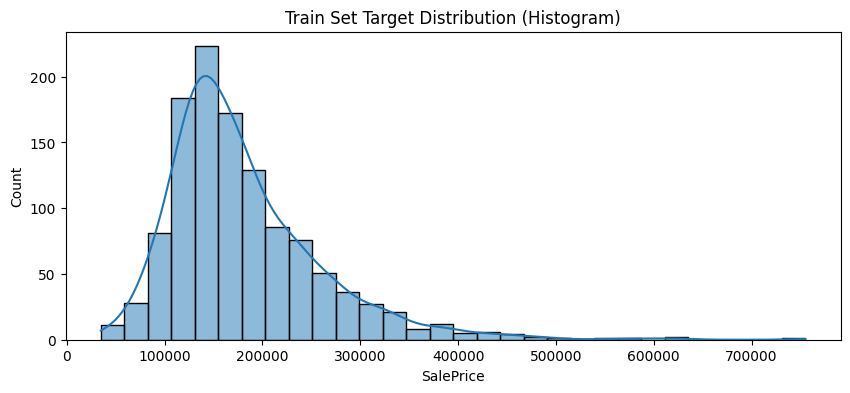

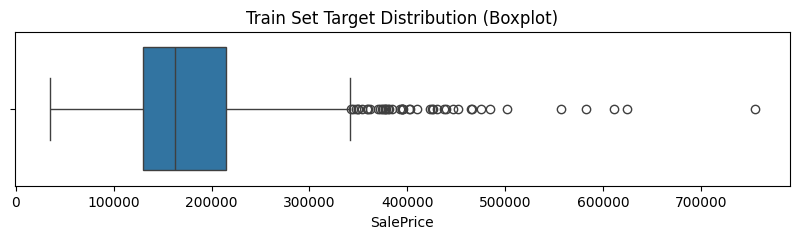

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Train Set Target Distribution (Histogram)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=y_train)
plt.title("Train Set Target Distribution (Boxplot)")
plt.xlabel("SalePrice")
plt.show()

### Log transform on target variable

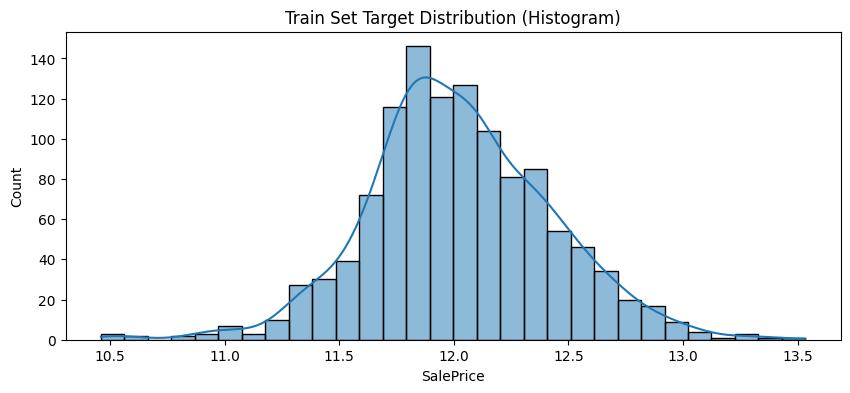

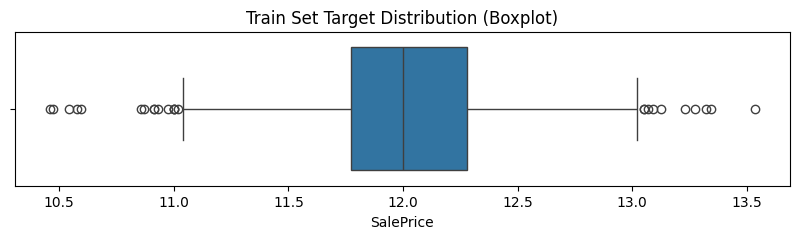

In [11]:
import numpy as np

y_train = np.log(y_train)
y_test = np.log(y_test)

import seaborn as sns
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Train Set Target Distribution (Histogram)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=y_train)
plt.title("Train Set Target Distribution (Boxplot)")
plt.xlabel("SalePrice")
plt.show()

## Grid Search CV - Sklearn

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


models_quick_search = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=0),
    'Ridge': Ridge(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'ElasticNet': {},
    'Ridge': {},
    'Lasso': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Hyperparameter optimisation search using default hyperparameters

In [26]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ElasticNet 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Ridge 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages

Check Results

In [27]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,Ridge,0.810693,0.865412,0.897545,0.031734
0,LinearRegression,0.810297,0.865364,0.897642,0.031894
5,GradientBoostingRegressor,0.728807,0.798964,0.848408,0.040985
6,XGBRegressor,0.740816,0.794685,0.828566,0.0328
4,RandomForestRegressor,0.697962,0.758146,0.853135,0.052973
3,DecisionTreeRegressor,0.618418,0.650013,0.684023,0.024744
1,ElasticNet,-0.01848,-0.004796,-0.000017,0.006958


Observations:
- Ridge and LinearRegression are best performing with default hyperparameters - highest mean R2 score and relatively low std dev
- ElasticNet is the worst performing 
- GradientBoosting is a strong runner up 

## Extensive search on most suitable model

Define model and parameters

In [ ]:

models_search = {
    "Lasso": Lasso(random_state=0),
}

params_search = {
    "Lasso": {
        'model__alpha': np.logspace(-4, 2, 50),
        'model__max_iter': [1000, 5000, 10000],
        'model__tol': [1e-3, 1e-4, 1e-5],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check best model

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define best regressor, based on search

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Assessing Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2

# partial pipeline up to feature engineering
pipeline_up_to_feat_eng = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
X_train_cleaned = pipeline_up_to_feat_eng.transform(X_train)

# column name after pre-processing
if isinstance(X_train_cleaned, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_train_cleaned.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns

# features selected
support_mask = best_regressor_pipeline['feat_selection'].get_support()
best_features = columns_after_data_cleaning_feat_eng[support_mask].to_list()

# coefficients from final lasso model
coefs = best_regressor_pipeline['model'].coef_

# create dataframe
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Coefficient': coefs
}).assign(Importance=lambda df: np.abs(df['Coefficient'])).sort_values(by='Importance', ascending=False)

# absolute importance
df_feature_importance['Importance'] = df_feature_importance['Coefficient'].abs()

# filter by threshold
threshold = 0.3 * df_feature_importance['Importance'].max()

important_df = df_feature_importance[df_feature_importance['Importance'] >= threshold]
important_df = important_df.sort_values(by='Importance', ascending=False)

print(f"* These are the {important_df.shape[0]} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

important_df.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Observations:
- R2 for Test set is too low (<0.7) 
- Considering hyperparameter tuning, feature engineering (dropping features that might be adding noise) and different models